# 2D Ising model Monte Carlo code 
This is a minimalistic implementation of Metropolis MC to solve the Ising model with nearest neighbor interactions on a square lattice. It can easily be generalized to 3D model but 2D is nice as it is exactly solvable. One can also include an externally applied magentic field with minal edits (include term $-b\sum_j \sigma_j$ in below and change $\Delta E$ accordingly). 
## The Model
$$E = - J\sum_{<ij>}\sigma_i \sigma_j$$
Here $J>0$ is a coupling coefficient that we will set to $1$ (becomes our unit if energy) and $\sigma_i \in \{\pm 1\}$ is the spin on site $i$. $<ij>$ means we only sum over the nearest neighboring pairs $(i,j)$
To increase performance we used the fact that each spin flip will correspond to a finite number of possible energy changes. So we can create a look-up table as a hash with all possible values to avoid reduntant and costly valutations of exponential functions. Say we flip the spin on site $a$ such that $\sigma_a \to -\sigma_a$, then the energy cost of this flip is  

$$\Delta E = \sum_{j}' 2\sigma_a\sigma_j = 2\sigma_a h$$
with $h = \sum_j' \sigma_j$ and the prime indicates sum over nearest neighbours to $a$ only. Since each site only has 4 nearest neighbours and each spin can only be $\pm 1$ the possible values of $h$ are $0, \pm 2, \pm 4$. Since we only need a probability when the energy cost is greater than $0$ we only need $2$ values for the accaptence probabilites.  

## Measurments 
For the classical Ising model some natural quantities to measure is the order parameter $m = \lim_{b \to 0^+}\left\langle\frac 1N \sum_i \sigma_i \right\rangle$ and the energy density $\langle E\rangle /N$. We also introduce $\sigma = \frac 1N \sum_i \sigma_j$ and clearly $m = \lim_{b\to 0^+}\langle \sigma \rangle$. For the purpouse of identifying the phase transition one can look at the magnetic suspetibility $\chi = \frac{\partial m}{\partial b}\vert_{b=0}$ and the specific heat $C_V = \frac{\partial \langle \rangle E}{\partial T}$ since these two diverge at the critical temperature. Numerically taking a derivative is difficult so instead let us use the following identites,

$$C_V = \frac{d\langle E \rangle }{dT} = -\frac{1}{T^2}\frac{d}{d\beta}\left(\frac{\sum_{\{\sigma\}}E_\sigma e^{-\beta E_\sigma}}{\sum_{\{\sigma\}}e^{-\beta E_\sigma}}\right)= \frac{1}{T^2}\left(\langle E^2\rangle - \langle E \rangle^2\right)$$

The expectation values $\langle E \rangle$ and $\langle E^2 \rangle$ can both be estimated with MC. Similarly for magentic susceptibility,
$$\chi = \frac{\partial m}{\partial b} = \frac{N}{T}(\langle\sigma^2\rangle - \langle\sigma\rangle^2)$$

In [12]:
# CODE

import numpy as np

class Ising_MC_2D:
    def __init__(self, Nx, Ny, Temp, nwarm=800, nmeas=2000, ndecor=1):
        # Initialize constants 
        self.Nx = Nx            # Width of lattice
        self.Ny = Ny            # Height of lattice
        self.N = Nx*Ny          # Number of sites
        self.T = Temp           # Temperature
        self.nwarm = nwarm      # Number of warm-up sweeps to reach thermal equilibrium
        self.nmeas = nmeas      # Number of Monte Carlo measurments 
        self.ndecor = ndecor    # Number of subsweeps to get decorrelated samples in equilibrium
        self.sweeps = nwarm + nmeas*ndecor

        # Initialize lookup table
        self.prob_table = {4: np.exp(-8/self.T), 2: np.exp(-4/self.T)} 

        # Initialize spin configuration to be updated during the simulation
        self.spins = np.random.choice([-1, 1], size=(Nx,Ny))

        # Initialize measurments 
        self.magnetization = 0
        self.magnetization_squared = 0 
        self.energy = 0
        self.energy_squared = 0

        # Initialize energy and update it during the simulation to reduce repeated calculations
        self.energy_help = 0
        for i in range(Nx):
            for j in range(Ny):
                self.energy_help -= 0.5*self.spins[i,j]*(self.spins[(i+1)%Nx,j] +self.spins[(i-1)%Nx,j] + self.spins[i, (j-1)%Ny] +self.spins[i, (j+1)%Ny])

    def run_MC_simulation(self):
        for sweep in range(self.sweeps):
            for _ in range(self.N)
                # Pick random site
                i = np.random.randint(0,self.Nx)
                j = np.random.randint(0,self.Ny)
                
                # Calculate energy difference 
                h = self.spins[(i+1)%self.Nx, j] + self.spins[(i-1)%self.Nx, j] + self.spins[i, (j+1)%self.Ny] + self.spins[i, (j-1)%self.Ny] 
                if h*self.spins[i,j] <= 0:
                    self.energy_help += 2*h*self.spins[i,j]
                    self.spins[i,j] *= -1
                else:
                    p = np.random.rand()
                    if p <= self.prob_table.get(h*self.spins[i,j]):
                        self.energy_help += 2*h*self.spins[i,j]
                        self.spins[i,j] *= -1
            # Perform measurments 
            if sweep > self.nwarm and (sweep-self.nwarm)%self.ndecor == 0:
                # Magentic measuremnts 
                mag = np.abs(np.sum(self.spins)/self.N)  # Absolute value to not average to 0 since the GS is 2-fold degenerate 
                self.magnetization += mag
                self.magnetization_squared += mag**2 

                # Energy Measurments 
                self.energy += self.energy_help
                self.energy_squared += (self.energy_help)**2
        

# Run simulation
Now we run the simulation. To get independent samples we should really look at the correlation time which estimates how many steps it takes for a sample to become decorrelated with itself. For simplicity we have assumed that a full lattice sweep is enough to get decorrelated samples.

In [18]:
from MC_ising import * 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progression bar 


# Initialize 
Nx = 30
Ny = 30
N = Nx*Ny
n_indep_runs = 1
n_thermal_sweeps = 1000
n_meas = 8000
T_vals = np.linspace(1,4,150)
magnitization = np.zeros_like(T_vals)
mag_sus = np.zeros_like(T_vals)
energies = np.zeros_like(T_vals)
heat_capacity = np.zeros_like(T_vals)

for i, temp in enumerate(tqdm(T_vals)):
    mag_ = []
    energy_ = []
    chi_ = []
    cv_ = []
    for _ in range(n_indep_runs): #independent markov chains
        MC_simulation = Ising_MC_2D(Nx, Ny, temp, n_thermal_sweeps, n_meas)
        MC_simulation.run_MC_simulation()
        mag_.append(abs(MC_simulation.magnetization/MC_simulation.nmeas))
        chi_.append(N*(MC_simulation.magnetization_squared/MC_simulation.nmeas - (MC_simulation.magnetization/MC_simulation.nmeas)**2)/temp)
        energy_.append(MC_simulation.energy/MC_simulation.nmeas)
        cv_.append((MC_simulation.energy_squared/MC_simulation.nmeas - (MC_simulation.energy/MC_simulation.nmeas)**2)/(temp*temp))

    # Magnetic properties 
    magnitization[i] += np.mean(mag_)
    mag_sus[i] += np.mean(chi_)
    
    # Energy properties 
    energies[i] += np.mean(energy_)
    heat_capacity[i] += np.mean(cv_)


100%|████████████████████████████████████████████████████████████████| 150/150 [15:15<00:00,  6.11s/it]


# Make plots 

/var/folders/dl/91cl0wgj3pl9_04fpgytq8v80000gn/T/ipykernel_91973/269886857.py:6: RuntimeWarning: overflow encountered in sinh
  onsager_mag = (1-(np.sinh(2/onsager_Ts))**(-4))**(1/8)


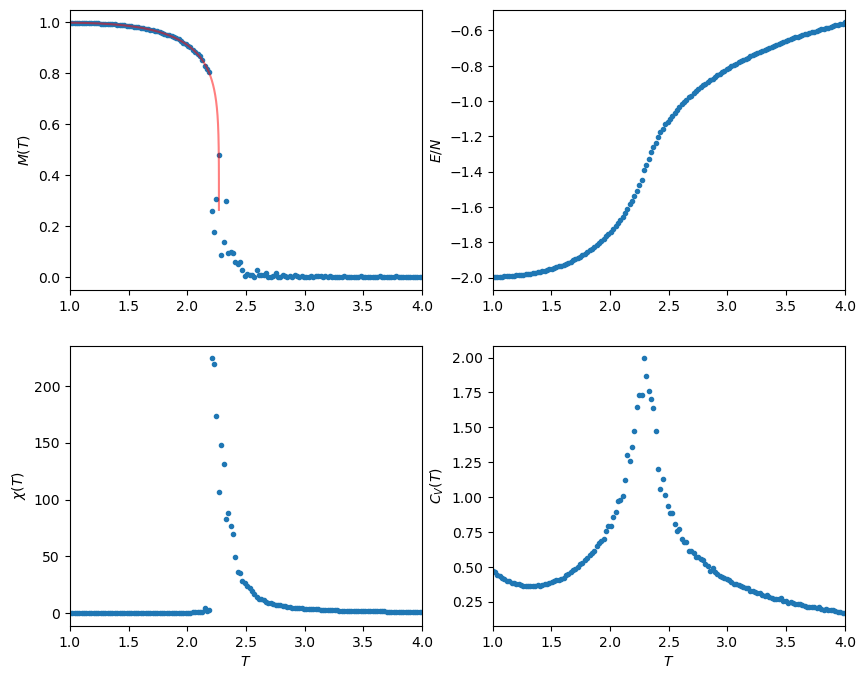

In [21]:
# Make plots
fig, axs = plt.subplots(2,2, figsize=(10,8))

# Top left
onsager_Ts = np.linspace(0.00001, 2/np.log(1+np.sqrt(2)+0.00001), 10000)
onsager_mag = (1-(np.sinh(2/onsager_Ts))**(-4))**(1/8)
axs[0,0].plot(T_vals, abs(magnitization), '.')
axs[0,0].plot(onsager_Ts, onsager_mag, color='red', alpha=0.5)
axs[0,0].set_ylabel(r"$M(T)$")
axs[0,0].set_xlim(1,4)

# Top right
axs[0,1].plot(T_vals, energies/N, '.')
axs[0,1].set_ylabel(r"$E/N$")
axs[0,1].set_xlim(1,4)

# Bottom left
axs[1,0].plot(T_vals, mag_sus, '.')
axs[1,0].set_ylabel(r"$\chi(T)$")
axs[1,0].set_xlabel(r"$T$")
axs[1,0].set_xlim(1,4)


axs[1,1].plot(T_vals, heat_capacity/N, '.')
axs[1,1].set_ylabel(r"$C_V(T)$")
axs[1,1].set_xlabel(r"$T$")
axs[1,1].set_xlim(1,4)

plt.show()

# Correlation time and relaxation time 

So far we assumed that a full lattice sweep is enough to decorrelate the configurations (since we do local updates clearly a single MC-step will yield highly-correlated samples). We also have just guessed the number of sweeps necessary to thermalize the sample. To more formally investigate this we introduce the non-linear correlation function,

$$\Phi_{th}(\tau) \equiv \frac{\langle \sigma(\tau)\rangle - \langle \sigma(\infty)\rangle}{\langle \sigma(\tau_0)\rangle - \langle \sigma(\infty)\rangle}$$

Here $\sigma = \frac1N \sum_i \sigma_i$. Since we know that the $\tau\to\infty$ limit should yield a stationary distribution the above function measures the time it takes for a measurment to thermalize. Often it decays exponentially and we can find the relaxation time $\tau_{th}$ by fitting. Likewise we can define a similar function to estimate how correlation decays with time,

$$\Phi_{corr} \equiv \frac{\langle \sigma(\tau)\sigma(\tau_0)\rangle - \langle \sigma(\tau_0)\rangle^2}{\langle \sigma(\tau_0)^2\rangle - \langle \sigma(\tau_0)\rangle^2}$$

Here $\tau_0$ is big enough such that we already reached equilibrium. Clearly the numerator will be $0$ if $\sigma(\tau)$ and $\sigma(\tau_0)$ are decorrelated and the function is initially normalized to $1$. Hence this measures correlation time. 

The time estimates are done using independent Markov Chains. Say we choose $M$ Markov chains all initialized at the same intial configuration $\sigma(0)$ chosen to be far from equilibrium. For each Markov chain we then do Metropolis updates as before and store the values 

In [148]:
### Code for  
import numpy as np
from tqdm import tqdm

# Markov chain class 
class markov_chain_thermal:
    def __init__(self, Nx, Ny, Temp):
        # Initialize 
        self.Nx = Nx
        self.Ny = Ny
        self.N = Nx*Ny
        self.T = Temp
        self.prob_table = {4: np.exp(-8/self.T), 2: np.exp(-4/self.T)}
        
        self.spins = np.random.choice([-1,1], size=(Nx,Ny))
    def MC_step(self):
        i = np.random.randint(0,self.Nx)
        j = np.random.randint(0,self.Ny)
                    
        # Calculate energy difference 
        h = self.spins[(i+1)%self.Nx, j] + self.spins[(i-1)%self.Nx, j] + self.spins[i, (j+1)%self.Ny] + self.spins[i, (j-1)%self.Ny] 
        if h*self.spins[i,j] <= 0:
            self.spins[i,j] *= -1
        else:
            p = np.random.rand()
            if p <= self.prob_table.get(h*self.spins[i,j]):
                self.spins[i,j] *= -1
        


Nx = 10
Ny = 10
T = 1
M = 300
L = 50*Nx*Ny #Time steps 
spin_avg_data = np.zeros((M,L))


for m in tqdm(range(M)):
    tmp_chain = markov_chain_thermal(Nx,Ny,T)
    for l in range(L):
        spin_avg_data[m,l] = np.abs(np.sum(tmp_chain.spins))
        tmp_chain.MC_step()
print("Done!")

100%|█████████████████████████████████████████| 300/300 [00:06<00:00, 45.62it/s]

Done!


Text(0.5, 1.0, '$\\tau = 8.656704647607018$')

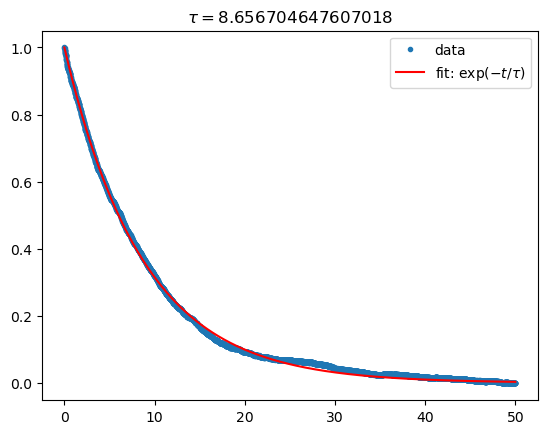

In [149]:
# Post data processing
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def fit_fun(x, tau):
    return np.exp(-x/tau)
    
# Get average <spins(tau)>
spin_avg = np.ones(M)@spin_avg_data/M # matrix mulitplication from the left with (1,1,1,...) to sum columns
norm = spin_avg[0] - spin_avg[-1]
nl_correlation = (spin_avg - spin_avg[-1])/norm

# Use a lattice sweep as time unit and fit to exponential 
x_data = np.arange(L)/(Nx*Ny)
coeff, var = curve_fit(fit_fun, x_data, nl_correlation)
plt.plot(x_data, nl_correlation, '.',label = 'data')
plt.plot(x_data, fit_fun(x_data, *coeff), label=rf'fit: exp($-t/\tau$)', color='red')
plt.legend()
plt.title(rf"$\tau = {coeff[0]}$")

In [1]:
### Code for  
import numpy as np
from tqdm import tqdm

# Markov chain class 
class markov_chain:
    def __init__(self, Nx, Ny, Temp):
        # Initialize 
        self.Nx = Nx
        self.Ny = Ny
        self.N = Nx*Ny
        self.T = Temp
        self.prob_table = {4: np.exp(-8/self.T), 2: np.exp(-4/self.T)}
        self.spins = np.random.choice([-1,1], size=(Nx,Ny))
        
        #if Temp < 2.25: # Ordered phase => dissordered phase far from equilibrium
        #    self.spins = np.zeros((Nx,Ny))
        #    for i in range(Nx):
        #        for j in range(Ny):
        #            self.spins[i,j] = 1-2*((i+j)%2)
        #else: 
        #    self.spins = np.ones((Nx,Ny)) # Disordered phase => ordered phase far from equilibrium 

    def MC_step(self):
        i = np.random.randint(0,self.Nx)
        j = np.random.randint(0,self.Ny)
                    
        # Calculate energy difference 
        h = self.spins[(i+1)%self.Nx, j] + self.spins[(i-1)%self.Nx, j] + self.spins[i, (j+1)%self.Ny] + self.spins[i, (j-1)%self.Ny] 
        if h*self.spins[i,j] <= 0:
            self.spins[i,j] *= -1
        else:
            p = np.random.rand()
            if p <= self.prob_table.get(h*self.spins[i,j]):
                self.spins[i,j] *= -1


Nx = 20
Ny = 20
T = 4
L = 10*Nx*Ny
equal = 1
M = 1000 # nr independent markov chains

spin_avg_data = np.zeros((M,equal*L,Nx,Ny))
for m in tqdm(range(M)):
    tmp_chain = markov_chain(Nx,Ny,T)
    for l in range((equal+1)*L):
        tmp_chain.MC_step()
        if l >= L:
            spin_avg_data[m,l-L,:,:] = tmp_chain.spins 
print("Done!")        


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.36it/s]

Done!


100%|██████████████████████████████████████| 4000/4000 [00:30<00:00, 130.96it/s]


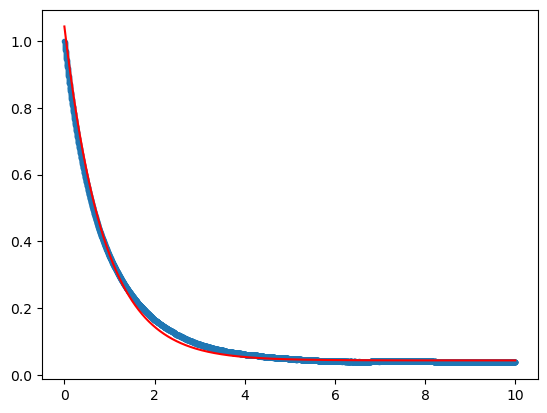

In [9]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
def fit_fun(x, tau, a):
    return np.exp(-x/tau) + a

    
x_data = np.arange(equal*L)/(Nx*Ny)
y_data = np.zeros(equal*L)
for l in tqdm(range(equal*L)):
    for m in range(M):
        norm = 1 - (abs(spin_avg_data[m,0,:,:].sum())**2)/(Nx*Nx*Ny*Ny)
        y_data[l] += (np.abs((spin_avg_data[m,l,:,:]*spin_avg_data[m,0,:,:]).sum())/(Nx*Ny) - (abs(spin_avg_data[m,0,:,:].sum())**2)/(Nx*Nx*Ny*Ny))/norm
coeff, var = curve_fit(fit_fun, x_data, y_data/M)
plt.plot(x_data,y_data/M, '.')
plt.plot(x_data, fit_fun(x_data, *coeff), color='red')